In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5e449e25b4718407315c4a6d049525961b6277521cdc5e3c90ecfcae95ee6308
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=ab4e51567d51f63e05720384dc879daf414eb41f28f0a802c277b12be6314ca1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
!pip3 install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
#!pip uninstall -y segmentation-models-pytorch

In [5]:
import torch
torch.cuda.is_available()

True

In [6]:
import tensorflow as tf
tf.version.VERSION

'2.15.0'

## Loading data

For this example we will use Monuseg dataset. It is a set of:
 - **train** images
 - **validation** images
 - **test** images

Your dataset must be organized as the follwing path direction structure to run the model smoothly


In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [8]:

x_train_dir = os.path.join('/content/drive/MyDrive/MiniProject/train folder/img')
y_train_dir = os.path.join('/content/drive/MyDrive/MiniProject/train folder/labelcol')

x_valid_dir = os.path.join('/content/drive/MyDrive/MiniProject/validation folder/img')
y_valid_dir = os.path.join('/content/drive/MyDrive/MiniProject/validation folder/labelcol')


In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [11]:
from skimage.io import imread

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    '''
    def __getitem__(self, idx: int) -> Dict[str, Any]:
        idx = idx % len(self.samples)

        image_path, mask_path = self.samples[idx]

        image = load_rgb(image_path, lib="cv2")
        mask = load_grayscale(mask_path)

        # apply augmentations
        sample = self.transform(image=image, mask=mask)
        image, mask = sample["image"], sample["mask"]

        mask = (mask > 0).astype(np.uint8)

        mask = torch.from_numpy(mask)
    '''

    #masks = np.zeros((24, 256, 256, 1), dtype=np.bool)

    def __getitem__(self, i):

        #dim = (480, 320)

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = np.zeros((256, 256), dtype=np.bool)
        mask_read = imread(self.masks_fps[i])
        mask = mask_read.astype(bool)
        mask = np.expand_dims(mask, axis=-1).astype(int)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


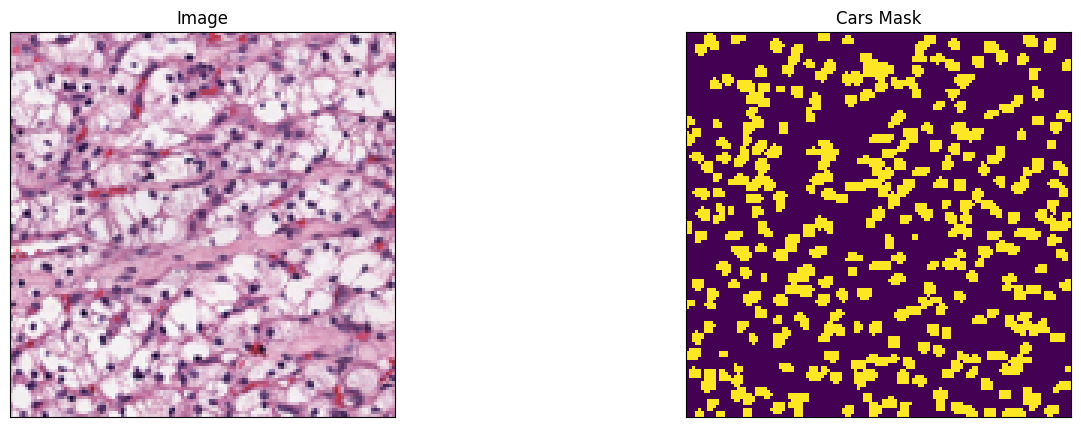

In [12]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[7] # get some sample

visualize(
    image=image,
    cars_mask=mask.squeeze(),
)

In [13]:
print (mask.shape)

(128, 128, 1)


### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [14]:
import albumentations as albu

In [15]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        albu.RandomCrop(height=256, width=256, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(256, 256)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

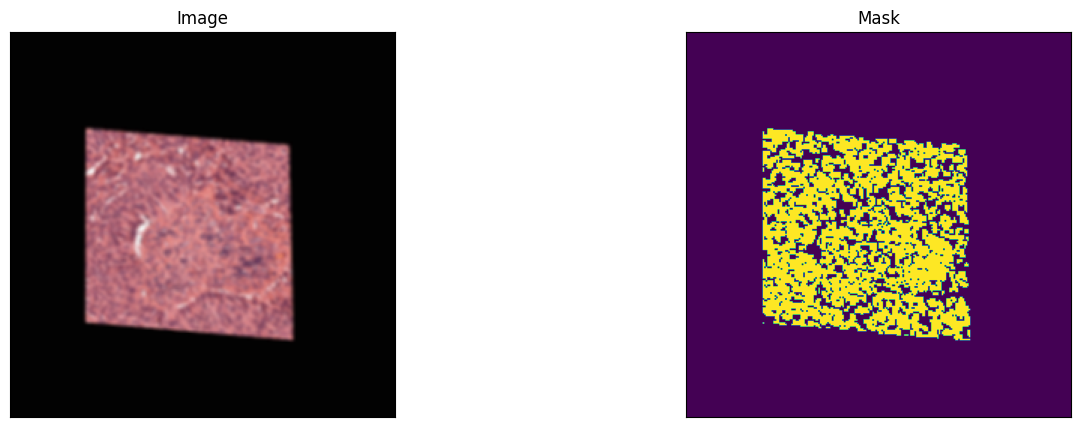

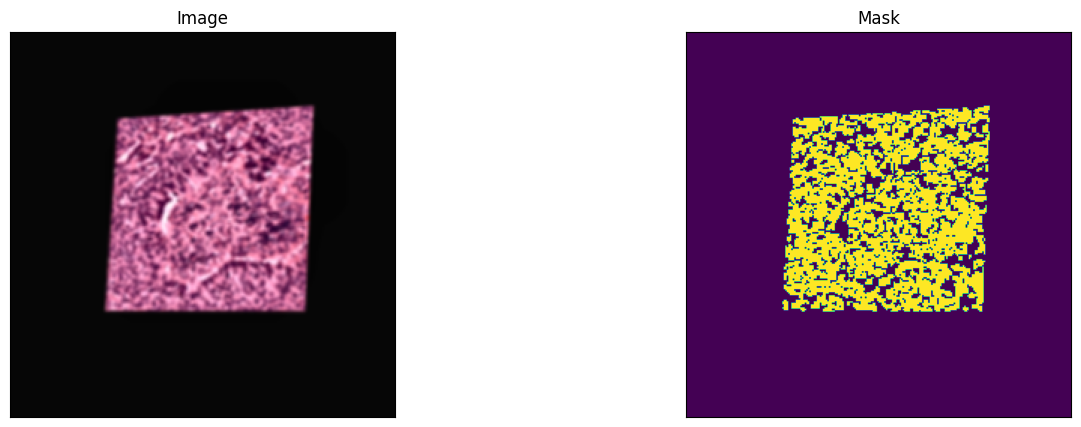

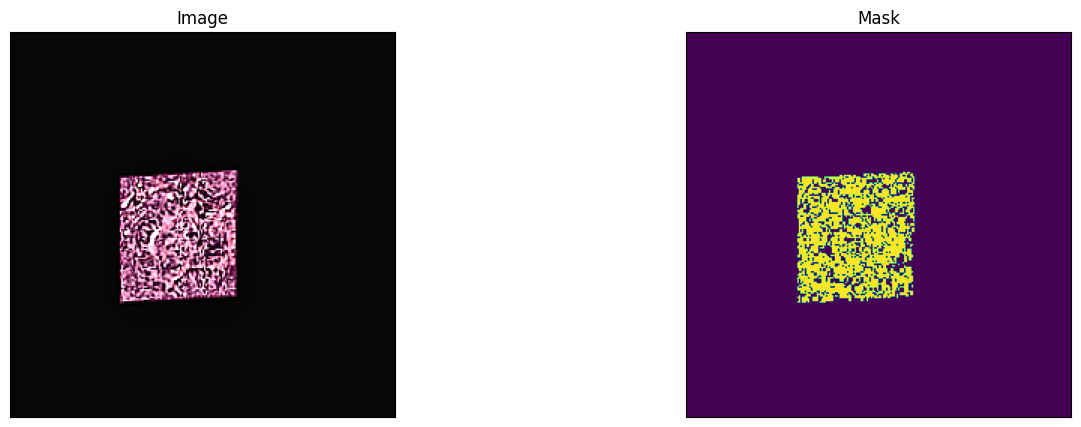

In [16]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['car'],
)

image, mask = augmented_dataset[9]

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[5]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [17]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smpUtils

In [18]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'tanh' # could be None for logits or 'softmax2d' for multiclass segmentation
#Pooling="avg"
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 234MB/s]


In [19]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

In [20]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smpUtils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.7),
    smp.utils.metrics.Fscore(threshold=0.7),
    smp.utils.metrics.Accuracy(threshold=0.7),
    smp.utils.metrics.Recall(threshold=0.7),
    smp.utils.metrics.Precision(threshold=0.7),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.5),
])

In [21]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [22]:
# train model for 280 epochs
max_score = 0

for i in range(0, 280):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/MiniProject/threshold_0.7_epoch_280_efficientnetb5_unet++_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


valid: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s, dice_loss - nan, iou_score - 3.605e-12, fscore - 3.605e-12, accuracy - 0.5464, recall - 3.605e-12, precision - 1.0]
Model saved!

Epoch: 1
valid: 100%|██████████| 6/6 [00:00<00:00, 15.25it/s, dice_loss - nan, iou_score - 3.605e-12, fscore - 3.605e-12, accuracy - 0.5464, recall - 3.605e-12, precision - 1.0]

Epoch: 2
valid: 100%|██████████| 6/6 [00:00<00:00, 14.26it/s, dice_loss - nan, iou_score - 3.605e-12, fscore - 3.605e-12, accuracy - 0.5464, recall - 3.605e-12, precision - 1.0]

Epoch: 3
valid: 100%|██████████| 6/6 [00:00<00:00, 20.16it/s, dice_loss - nan, iou_score - 3.605e-12, fscore - 3.605e-12, accuracy - 0.5464, recall - 3.605e-12, precision - 1.0]

Epoch: 4
valid: 100%|██████████| 6/6 [00:00<00:00, 20.02it/s, dice_loss - nan, iou_score - 3.605e-12, fscore - 3.605e-12, accuracy - 0.5464, recall - 3.605e-12, precision - 1.0]

Epoch: 5
valid: 100%|██████████| 6/6 [00:00<00:00, 12.54it/s, dice_loss - nan, iou_score - 3.605e-12,

## Test with MonuSeg

In [23]:
max_score1 = 0

for i in range(0, 430):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score1 < valid_logs['iou_score']:
        max_score1 = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/MiniProject/threshold_0.7_epoch_430_efficientnetb5_unet++_model.pth')
        print('Model saved!')

    if i == 50:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


valid: 100%|██████████| 6/6 [00:00<00:00, 19.77it/s, dice_loss - 0.544, iou_score - 0.3926, fscore - 0.5606, accuracy - 0.4021, recall - 0.898, precision - 0.4331]
Model saved!

Epoch: 1
valid: 100%|██████████| 6/6 [00:00<00:00, 21.19it/s, dice_loss - 0.5318, iou_score - 0.3961, fscore - 0.5643, accuracy - 0.4045, recall - 0.9065, precision - 0.4348]
Model saved!

Epoch: 2
valid: 100%|██████████| 6/6 [00:00<00:00, 19.67it/s, dice_loss - 0.5279, iou_score - 0.3971, fscore - 0.5654, accuracy - 0.4051, recall - 0.9084, precision - 0.4352]
Model saved!

Epoch: 3
valid: 100%|██████████| 6/6 [00:00<00:00, 20.33it/s, dice_loss - 0.5244, iou_score - 0.398, fscore - 0.5662, accuracy - 0.4057, recall - 0.9099, precision - 0.4355]
Model saved!

Epoch: 4
valid: 100%|██████████| 6/6 [00:00<00:00, 13.71it/s, dice_loss - 0.5238, iou_score - 0.3981, fscore - 0.5664, accuracy - 0.4058, recall - 0.9101, precision - 0.4356]
Model saved!

Epoch: 5
valid: 100%|██████████| 6/6 [00:00<00:00, 16.56it/s, dice_

In [24]:
max_score2 = 0

for i in range(0, 580):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score2 < valid_logs['iou_score']:
        max_score2 = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/MiniProject/threshold_0.7_epoch_580_efficientnetb5_unet++_model.pth')
        print('Model saved!')

    if i == 100:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


valid: 100%|██████████| 6/6 [00:00<00:00, 20.18it/s, dice_loss - 0.532, iou_score - 0.3961, fscore - 0.5643, accuracy - 0.4044, recall - 0.9065, precision - 0.4347]
Model saved!

Epoch: 1
valid: 100%|██████████| 6/6 [00:00<00:00, 15.28it/s, dice_loss - 0.5272, iou_score - 0.3973, fscore - 0.5655, accuracy - 0.4052, recall - 0.9088, precision - 0.4352]
Model saved!

Epoch: 2
valid: 100%|██████████| 6/6 [00:00<00:00, 16.01it/s, dice_loss - 0.5363, iou_score - 0.3952, fscore - 0.5633, accuracy - 0.4038, recall - 0.9047, precision - 0.4344]

Epoch: 3
valid: 100%|██████████| 6/6 [00:00<00:00, 20.80it/s, dice_loss - 0.5399, iou_score - 0.3944, fscore - 0.5624, accuracy - 0.4032, recall - 0.9032, precision - 0.434]

Epoch: 4
valid: 100%|██████████| 6/6 [00:00<00:00, 15.89it/s, dice_loss - 0.5394, iou_score - 0.3945, fscore - 0.5626, accuracy - 0.4033, recall - 0.9034, precision - 0.434]

Epoch: 5
valid: 100%|██████████| 6/6 [00:00<00:00, 20.47it/s, dice_loss - 0.5452, iou_score - 0.3931, fsco

In [25]:
max_score3 = 0

for i in range(0, 730):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score3 < valid_logs['iou_score']:
        max_score3 = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/MiniProject/threshold_0.7_epoch_730_efficientnetb5_unet++_model.pth')
        print('Model saved!')

    if i == 200:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


valid: 100%|██████████| 6/6 [00:00<00:00, 19.10it/s, dice_loss - 0.5528, iou_score - 0.3916, fscore - 0.5594, accuracy - 0.4013, recall - 0.8978, precision - 0.4328]
Model saved!

Epoch: 1
valid: 100%|██████████| 6/6 [00:00<00:00, 19.87it/s, dice_loss - 0.5592, iou_score - 0.3902, fscore - 0.558, accuracy - 0.4005, recall - 0.8951, precision - 0.4322]

Epoch: 2
valid: 100%|██████████| 6/6 [00:00<00:00, 21.05it/s, dice_loss - 0.5553, iou_score - 0.391, fscore - 0.5589, accuracy - 0.401, recall - 0.8968, precision - 0.4325]

Epoch: 3
valid: 100%|██████████| 6/6 [00:00<00:00, 16.10it/s, dice_loss - 0.5471, iou_score - 0.3929, fscore - 0.5608, accuracy - 0.4022, recall - 0.9004, precision - 0.4334]
Model saved!

Epoch: 4
valid: 100%|██████████| 6/6 [00:00<00:00, 14.96it/s, dice_loss - 0.5428, iou_score - 0.3938, fscore - 0.5618, accuracy - 0.4029, recall - 0.9023, precision - 0.4338]
Model saved!

Epoch: 5
valid: 100%|██████████| 6/6 [00:00<00:00, 20.03it/s, dice_loss - 0.5551, iou_score -

In [26]:
max_score4 = 0

for i in range(0, 880):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score4 < valid_logs['iou_score']:
        max_score4 = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/MiniProject/threshold_0.5_epoch_880_efficientnetb5_unet++_model.pth')
        print('Model saved!')

    if i == 250:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


valid: 100%|██████████| 6/6 [00:00<00:00, 14.83it/s, dice_loss - 0.6081, iou_score - 0.3785, fscore - 0.5455, accuracy - 0.3927, recall - 0.8687, precision - 0.4267]
Model saved!

Epoch: 1
valid: 100%|██████████| 6/6 [00:00<00:00, 12.87it/s, dice_loss - 0.5983, iou_score - 0.3805, fscore - 0.5477, accuracy - 0.394, recall - 0.873, precision - 0.4277]
Model saved!

Epoch: 2
valid: 100%|██████████| 6/6 [00:00<00:00, 17.17it/s, dice_loss - 0.6029, iou_score - 0.3796, fscore - 0.5467, accuracy - 0.3934, recall - 0.8711, precision - 0.4273]

Epoch: 3
valid: 100%|██████████| 6/6 [00:00<00:00, 18.89it/s, dice_loss - 0.5938, iou_score - 0.3817, fscore - 0.5489, accuracy - 0.3948, recall - 0.8756, precision - 0.4283]
Model saved!

Epoch: 4
valid: 100%|██████████| 6/6 [00:00<00:00, 16.71it/s, dice_loss - 0.5988, iou_score - 0.3805, fscore - 0.5476, accuracy - 0.394, recall - 0.873, precision - 0.4277]

Epoch: 5
valid: 100%|██████████| 6/6 [00:00<00:00, 15.14it/s, dice_loss - 0.6015, iou_score - 

In [27]:
max_score5 = 0

for i in range(0, 1030):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score5 < valid_logs['iou_score']:
        max_score5 = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/MiniProject/threshold_0.5_epoch_1030_efficientnetb5_unet++_model.pth')
        print('Model saved!')

    if i == 400:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


valid: 100%|██████████| 6/6 [00:00<00:00, 18.68it/s, dice_loss - 0.7264, iou_score - 0.3567, fscore - 0.5214, accuracy - 0.3798, recall - 0.8192, precision - 0.4164]
Model saved!

Epoch: 1
valid: 100%|██████████| 6/6 [00:00<00:00, 16.61it/s, dice_loss - 0.7442, iou_score - 0.3538, fscore - 0.5181, accuracy - 0.3783, recall - 0.8121, precision - 0.415]

Epoch: 2
valid: 100%|██████████| 6/6 [00:00<00:00, 19.37it/s, dice_loss - 0.7201, iou_score - 0.3577, fscore - 0.5225, accuracy - 0.3803, recall - 0.8214, precision - 0.4169]
Model saved!

Epoch: 3
valid: 100%|██████████| 6/6 [00:00<00:00, 18.06it/s, dice_loss - 0.7379, iou_score - 0.3548, fscore - 0.5192, accuracy - 0.3788, recall - 0.8145, precision - 0.4154]

Epoch: 4
valid: 100%|██████████| 6/6 [00:00<00:00, 15.69it/s, dice_loss - 0.738, iou_score - 0.3548, fscore - 0.5193, accuracy - 0.3789, recall - 0.8146, precision - 0.4155]

Epoch: 5
valid: 100%|██████████| 6/6 [00:00<00:00, 14.88it/s, dice_loss - 0.7281, iou_score - 0.3563, fsc

In [46]:
# load best saved checkpoint
best_model = torch.load('/content/drive/MyDrive/MiniProject/threshold_0.7_epoch_430_efficientnetb5_unet++_model.pth')

In [38]:
# download tnbc dataset
!gdown --id 19Te1OC8fs6_I4bkVJjQgKw-9f2ETpcqI

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19Te1OC8fs6_I4bkVJjQgKw-9f2ETpcqI
To: /content/tnbc_dataset.zip
100% 24.8M/24.8M [00:00<00:00, 141MB/s]


In [30]:
!rm -r tnbc_dataset

rm: cannot remove 'tnbc_dataset': No such file or directory


In [39]:
!mkdir tnbc_dataset
!7z x tnbc_dataset.zip -o/content/tnbc_dataset/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 24784213 bytes (24 MiB)

Extracting archive: tnbc_dataset.zip
--
Path = tnbc_dataset.zip
Type = zip
Physical Size = 24784213

  0%    Everything is Ok

Files: 100
Size:       24761513
Compressed: 24784213


In [40]:
x_test_dir = os.path.join('/content/drive/MyDrive/MiniProject/test folder/img')
y_test_dir = os.path.join('/content/drive/MyDrive/MiniProject/test folder/labelcol')

TNBC_x_test_dir = os.path.join('/content/tnbc_dataset/test folder/img')
TNBC_y_test_dir = os.path.join('/content/tnbc_dataset/test folder/labelcol')


In [47]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [49]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid:  14%|█▍        | 2/14 [00:00<00:00, 15.45it/s, dice_loss - -2.273, iou_score - 0.3509, fscore - 0.4775, accuracy - 0.4598, recall - 0.653, precision - 0.4079] 

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


valid: 100%|██████████| 14/14 [00:00<00:00, 16.56it/s, dice_loss - 0.3163, iou_score - 0.3086, fscore - 0.4548, accuracy - 0.3866, recall - 0.7161, precision - 0.36]


## Visualize predictions

In [50]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir,
    classes=CLASSES,
)

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


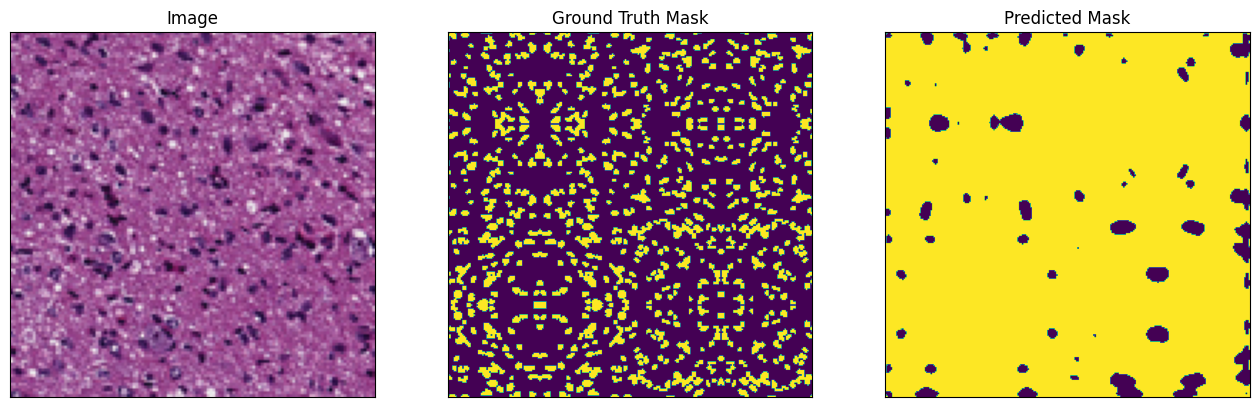

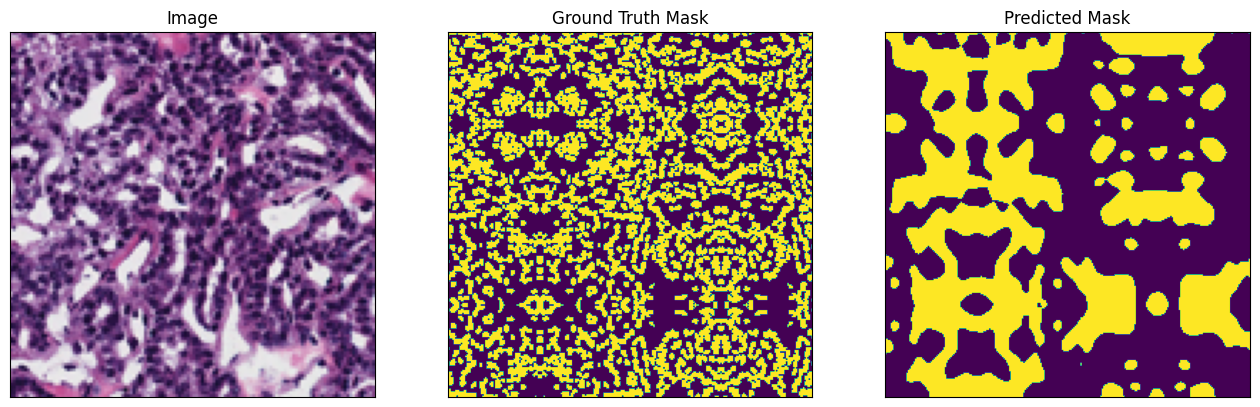

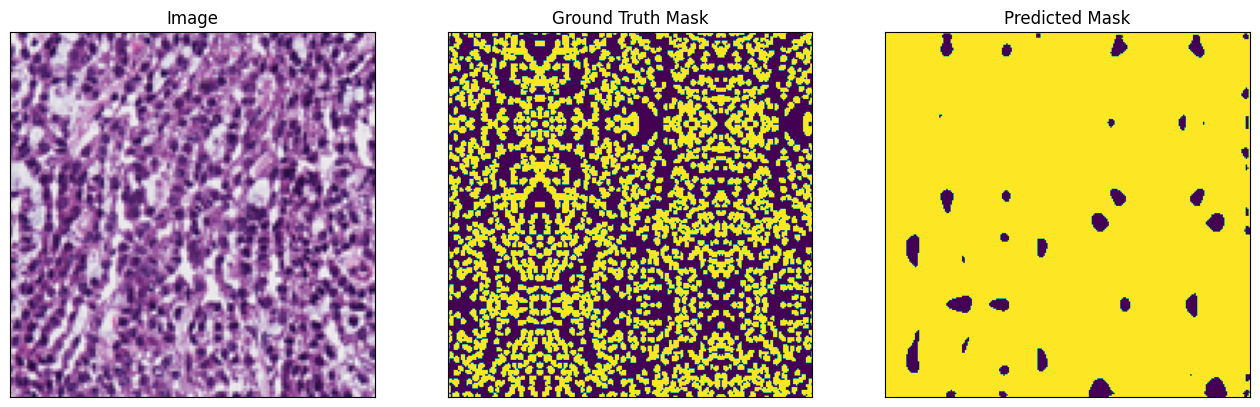

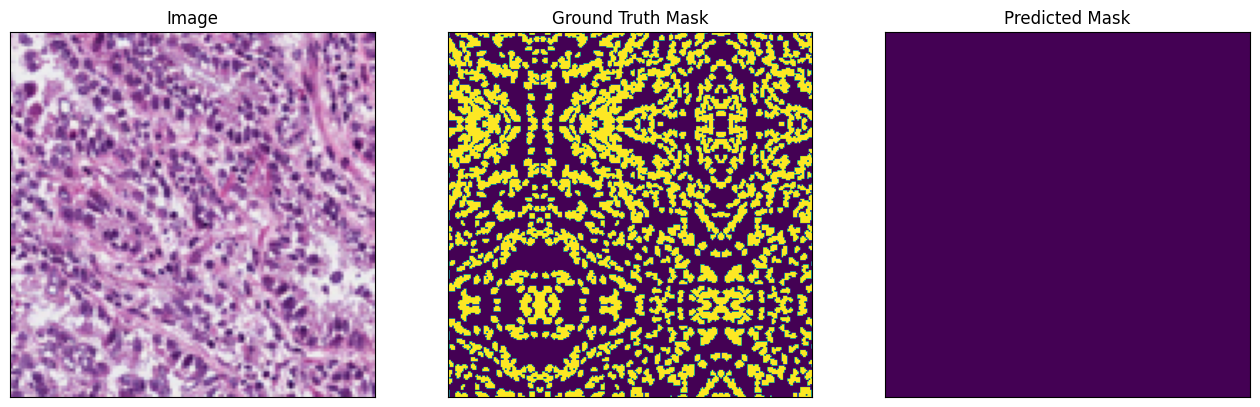

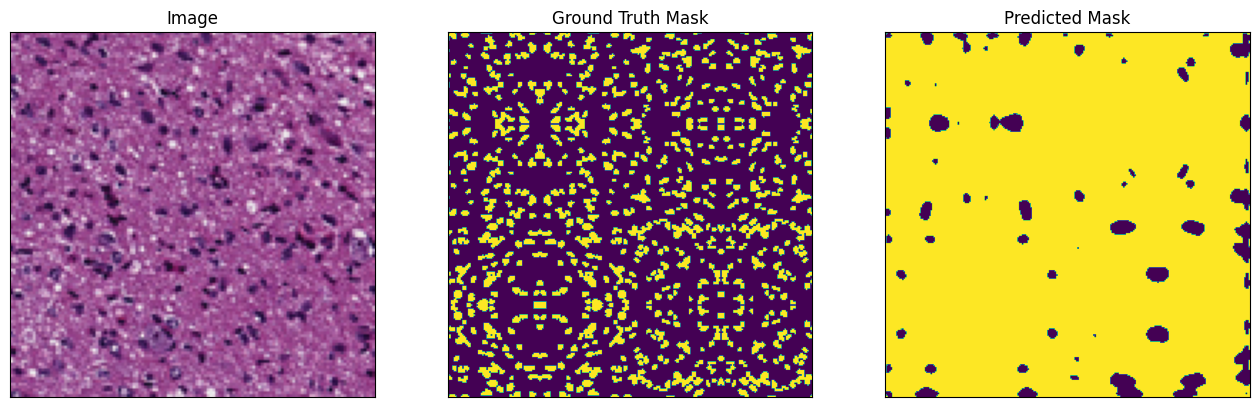

In [51]:
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )

## Test with TNBC

In [52]:
# create test dataset
TNBC_test_dataset = Dataset(
    TNBC_x_test_dir,
    TNBC_y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

TNBC_test_dataloader = DataLoader(TNBC_test_dataset)

In [53]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(TNBC_test_dataloader)

valid:  10%|█         | 1/10 [00:00<00:01,  8.97it/s, dice_loss - 0.9832, iou_score - 0.008476, fscore - 0.01681, accuracy - 0.008476, recall - 1.0, precision - 0.008476]

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


valid: 100%|██████████| 10/10 [00:00<00:00, 10.71it/s, dice_loss - 0.8109, iou_score - 0.1119, fscore - 0.1891, accuracy - 0.1119, recall - 1.0, precision - 0.1119]


In [43]:
# test dataset without transformations for image visualization
TNBC_test_dataset_vis = Dataset(
    TNBC_x_test_dir, TNBC_y_test_dir,
    classes=CLASSES,
)

<ipython-input-11-ece82b245040>:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((256, 256), dtype=np.bool)


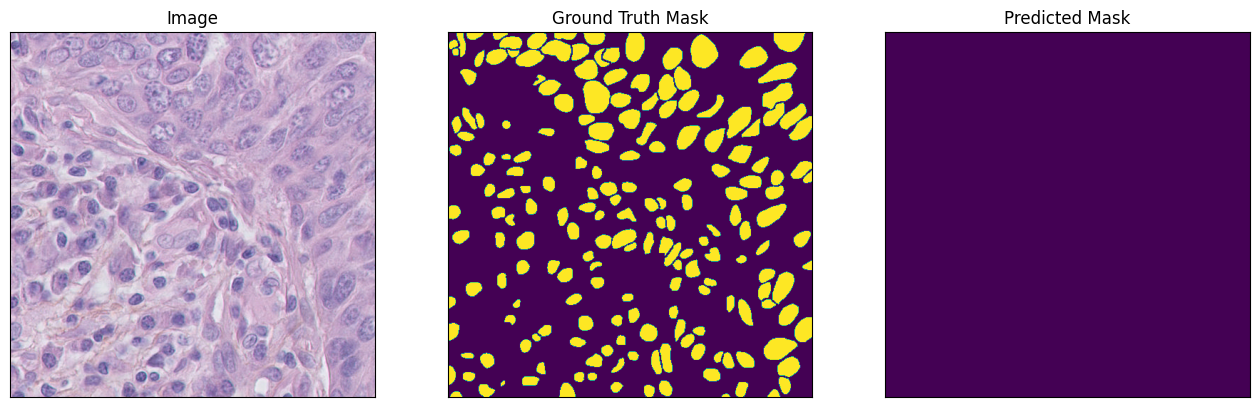

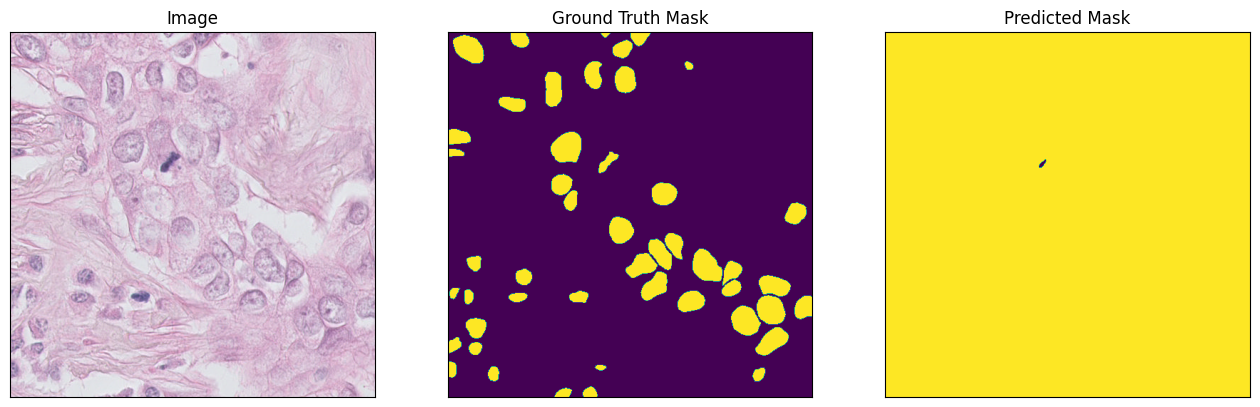

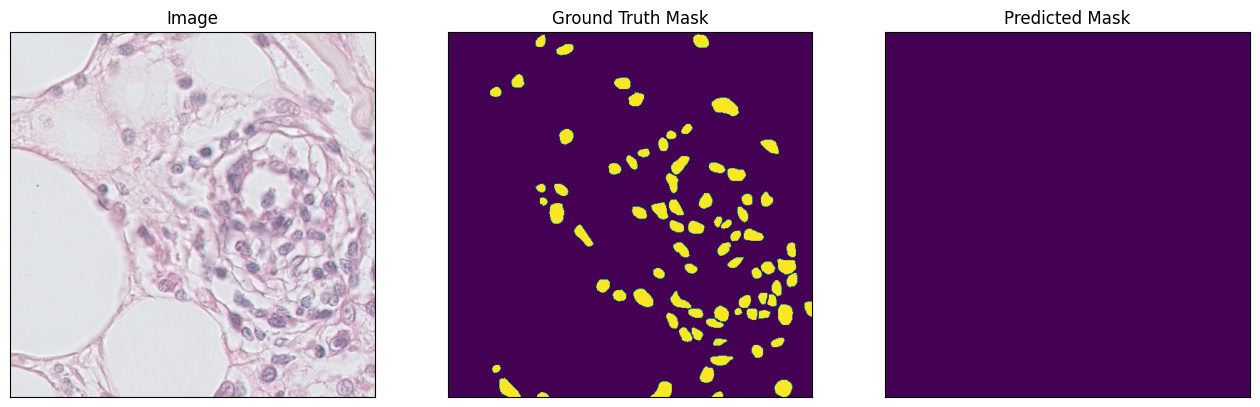

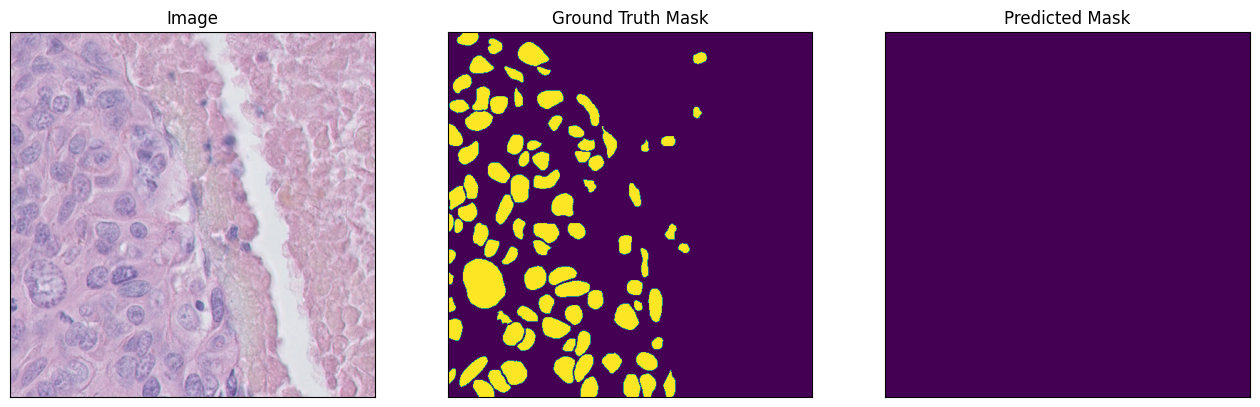

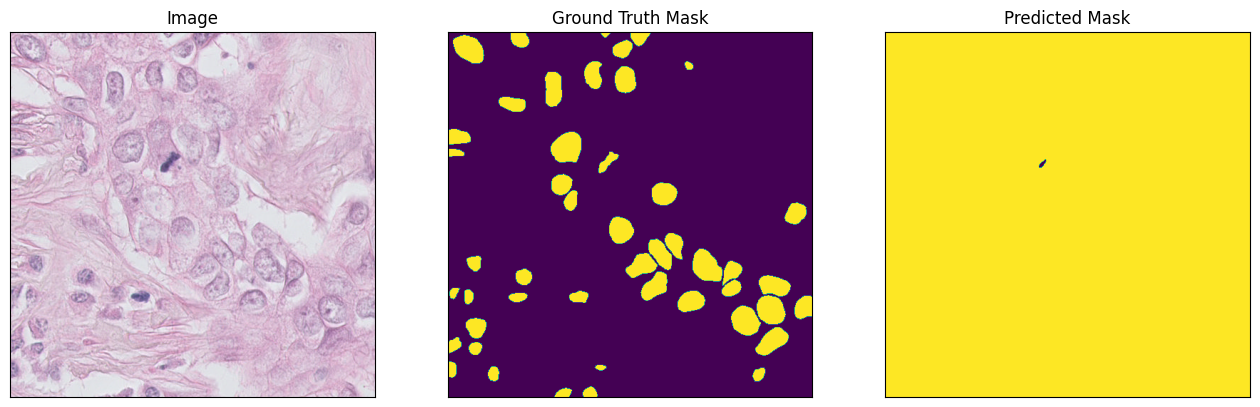

In [44]:
for i in range(5):
    n = np.random.choice(len(TNBC_test_dataset))

    image_vis = TNBC_test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = TNBC_test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )